In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Flatten, Dense, MaxPool2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 20
CHANNEL = 3
EPOCHS = 20

In [ ]:
# IF BELOW CELL DOES'NT WORK USE THIS METHOD
# Replace 'folder_id' with the actual folder ID from the shared link
# folder_id = 'abcd1234efgh5678ijkl'

# # Construct the shared folder link
# shared_folder_link = f'/content/drive/MyDrive/{folder_id}'

# # Use the shared folder link to access the contents
# dataset_path = shared_folder_link


In [ ]:
dataset_path = '/content/drive/MyDrive/PlantVillage'
# dataset_path = '/content/drive/shared-with-me/PlantVillage' #For shared data
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 1791 files belonging to 10 classes.


In [ ]:
classes = dataset.class_names
print(classes)
print(len(classes))

['Pepper_bell___Bacterial_spot', 'Pepper_bell___healthy', 'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Tomato_mosaic_virus', 'Tomato_healthy']
10


In [ ]:
len(dataset)

90

(224, 224, 3)


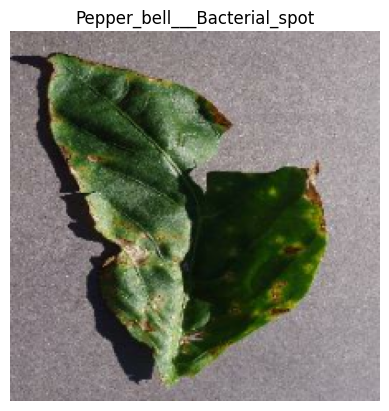

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].shape)
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(classes[label_batch[0]])
  plt.axis("off")

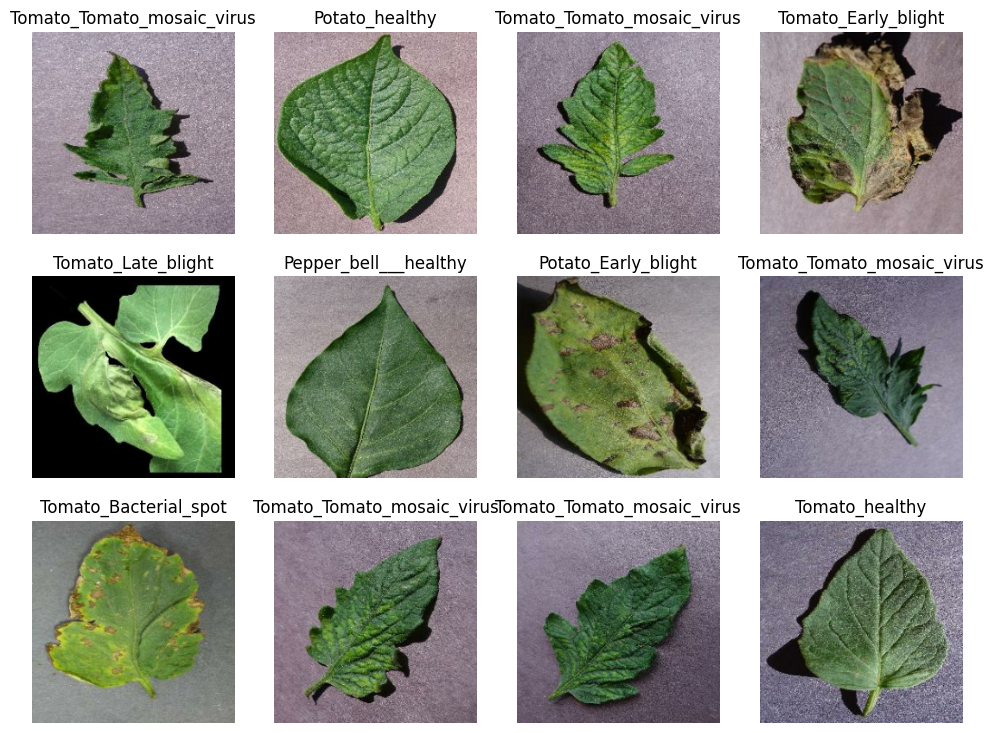

In [ ]:
plt.figure(figsize=(12, 9))

for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")


## Train Test Split

In [ ]:
len(dataset)

90

In [ ]:
# 80% --> training
# 20% --> 10% validation, 10% test

In [ ]:
train_size = 0.8
len(dataset)*train_size

72.0

In [ ]:
train_ds = dataset.take(72)
len(train_ds)

72

In [ ]:
test_ds = dataset.skip(72)
len(test_ds)

18

In [ ]:
val_size = 0.1
len(dataset)*val_size

9.0

In [ ]:
test_ds = test_ds.skip(9)
len(test_ds)

9

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)


  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Length of training: ", len(train_ds))
print("Length of validation: ", len(val_ds))
print("Length of test: ", len(test_ds))

Length of training:  72
Length of validation:  9
Length of test:  9


In [ ]:
resize_and_rescalling = tf.keras.Sequential([
    layers.Rescaling(1.0/255),  # Rescale pixel values to [0, 1]
    layers.Resizing(IMG_SIZE, IMG_SIZE)
    ])

## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    layers.RandomRotation(0.2)  # Randomly rotate images by up to 20 degrees
])

## Modeling ResNet50

In [ ]:
from keras.applications import ResNet50

input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL)
n_classes = 10

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNEL))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescalling,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),  # Replace Flatten layer with GlobalAveragePooling2D
    layers.Dense(n_classes, activation="softmax")  # Output layer for classification
])

In [ ]:
model.build(input_shape=(32, 224, 224, 3))

In [ ]:
model.compile(
    optimizer="Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (32, 2048)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (32, 10)                  20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
72/72 [==============================] - 22s 149ms/step - loss: 2.3368 - accuracy: 0.1125 - val_loss: 2.2796 - val_accuracy: 0.1056
Epoch 2/20
72/72 [==============================] - 14s 146ms/step - loss: 2.2782 - accuracy: 0.1328 - val_loss: 2.2343 - val_accuracy: 0.2111
Epoch 3/20
72/72 [==============================] - 12s 124ms/step - loss: 2.2375 - accuracy: 0.2061 - val_loss: 2.1939 - val_accuracy: 0.2167
Epoch 4/20
72/72 [==============================] - 12s 126ms/step - loss: 2.2128 - accuracy: 0.1908 - val_loss: 2.1539 - val_accuracy: 0.2500
Epoch 5/20
72/72 [==============================] - 12s 132ms/step - loss: 2.1725 - accuracy: 0.2138 - val_loss: 2.1019 - val_accuracy: 0.2690
Epoch 6/20
72/72 [==============================] - 13s 135ms/step - loss: 2.1764 - accuracy: 0.2194 - val_loss: 2.1603 - val_accuracy: 0.2444
Epoch 7/20
72/72 [==============================] - 13s 143ms/step - loss: 2.1224 - accuracy: 0.2618 - val_loss: 2.1103 - val_accuracy: 0.2889

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Visualizing Accuracy

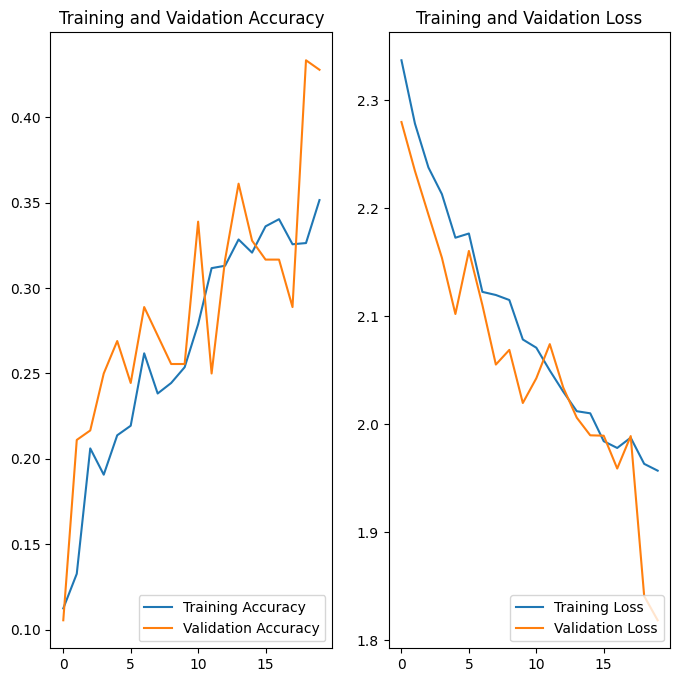

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Vaidation Accuracy")

#For loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Vaidation Loss")
plt.show()

## Testing

First image to predict
Actual Label:  Tomato_Early_blight
1/1 [==============================] - 1s 1s/step
Predicted Label:  Tomato_Tomato_mosaic_virus


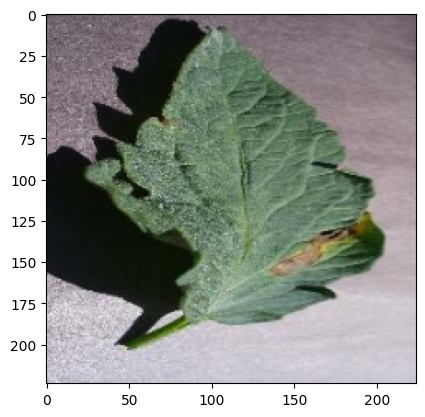

In [ ]:
import numpy as np

for images_batch, label_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("Actual Label: ", classes[first_label])

  batch_prediction = model.predict(image_batch)
  print("Predicted Label: ", classes[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = classes[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


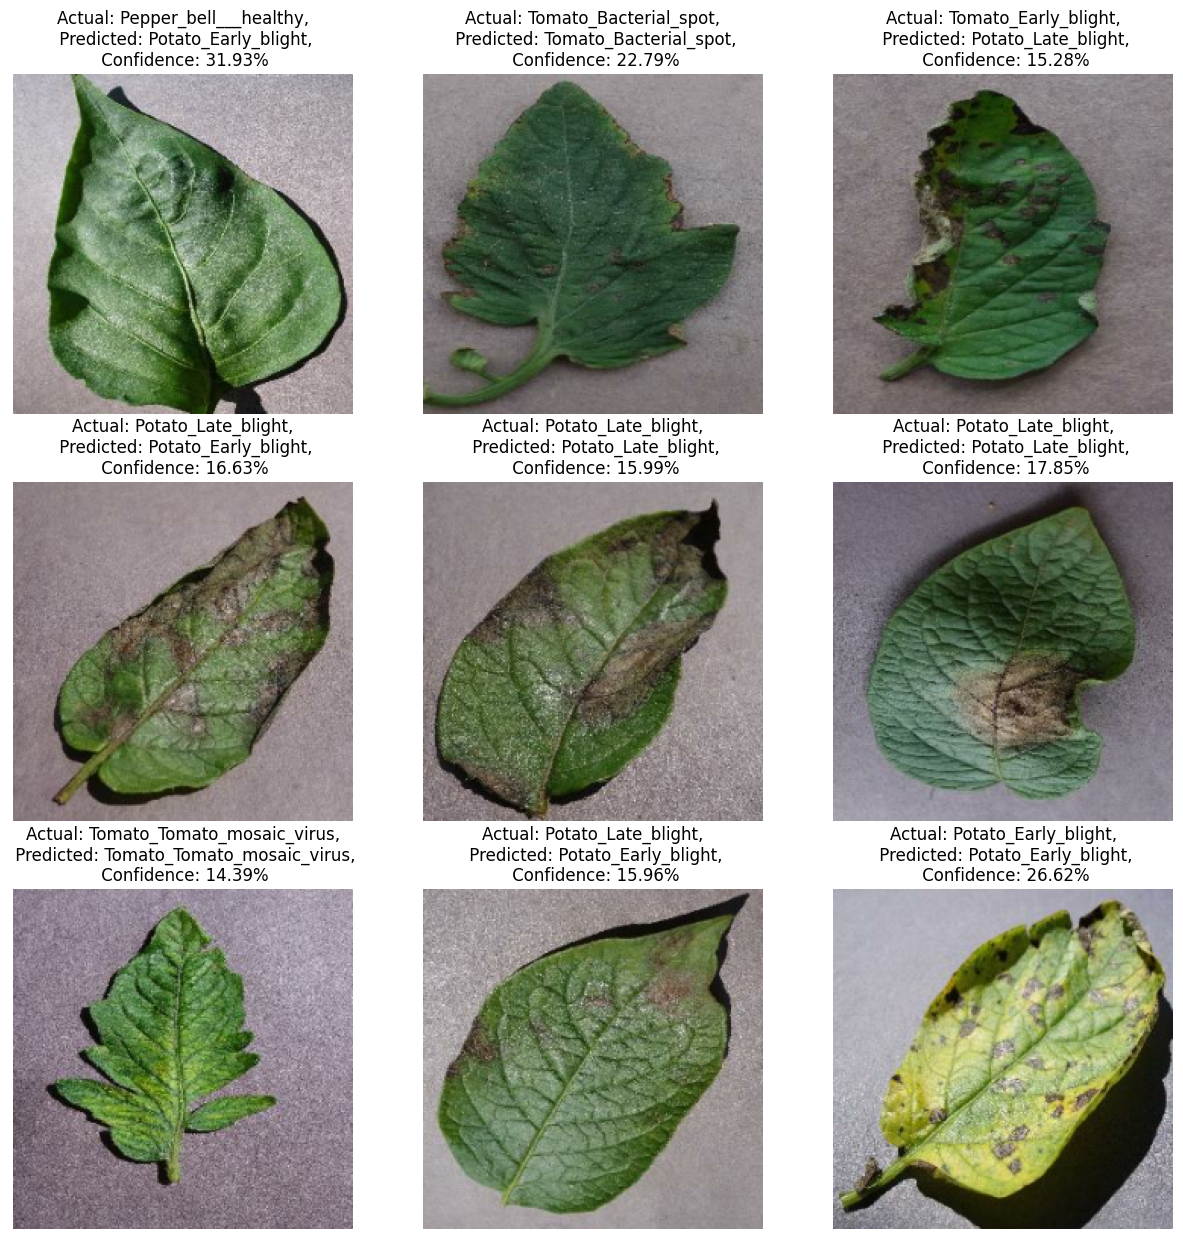

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = classes[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")

    plt.axis("off")

## Saving Model Version

In [ ]:
# Define your model version
model_version = 1  # You can set this based on your needs

# Save the model
model.save(f"modelResNet50_{model_version}")

# Download the saved model file
from google.colab import files
files.download(f"modelResNet50_{model_version}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define your model version
model_version = 1  # You can set this based on your needs

# Save the model
model.save(f"modelResNet50_{model_version}")

# Compress the saved model directory into a zip file
import shutil
shutil.make_archive(f"modelResNet50_{model_version}", 'zip', f"modelResNet50_{model_version}")

# Download the zip file
from google.colab import files
files.download(f"modelResNet50_{model_version}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>